In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import teotil3 as teo

plt.style.use("ggplot")

In [3]:
eng = nivapy.da.connect_postgis()

Connection successful.


# Comparing point and spredt inputs at regine level following migration to PostGIS

As part of the TEOTIL development work, I have migrated NIVA's entire "RID" database containing point and "spredt" inputs from Oracle into a new schema within JupyterHub's PostGIS database. The new database structure is simpler and tidier, but I want to check that my code for querying results from the new database gives broadly the same answer as previously using the old database.

In [4]:
year = 2020

## 1. Read input data generated for TEOTIL2

The code below reads input files generated for the old model from the Oracle database and changes column names and units to match those used by the new model.

In [5]:
# Read TEOTIL2 input file
file_url = f"https://raw.githubusercontent.com/NIVANorge/teotil2/main/data/norway_annual_input_data/input_data_{year}.csv"
teo2_df = pd.read_csv(file_url)

# Get cols of interest
cols = [
    "regine",
    "a_reg_km2",
    "runoff_mm/yr",
    "aqu_tot-n_tonnes",
    "aqu_tot-p_tonnes",
    "ind_tot-n_tonnes",
    "ind_tot-p_tonnes",
    "ren_tot-n_tonnes",
    "ren_tot-p_tonnes",
    "spr_tot-n_tonnes",
    "spr_tot-p_tonnes",
]
teo2_df = teo2_df[cols]

# Change col names and units to match new model
col_dict = {
    "aqu_tot-n_tonnes": "aquaculture_totn_kg",
    "aqu_tot-p_tonnes": "aquaculture_totp_kg",
    "ind_tot-n_tonnes": "industry_totn_kg",
    "ind_tot-p_tonnes": "industry_totp_kg",
    "ren_tot-n_tonnes": "wastewater_totn_kg",
    "ren_tot-p_tonnes": "wastewater_totp_kg",
    "spr_tot-n_tonnes": "spredt_totn_kg",
    "spr_tot-p_tonnes": "spredt_totp_kg",
}
for old, new in col_dict.items():
    teo2_df[new] = 1000 * teo2_df[old]
    del teo2_df[old]
teo2_df.rename({"a_reg_km2": "a_cat_land_km2"}, inplace=True, axis="columns")
teo2_df.head()

,regine,a_cat_land_km2,runoff_mm/yr,aquaculture_totn_kg,aquaculture_totp_kg,industry_totn_kg,industry_totp_kg,wastewater_totn_kg,wastewater_totp_kg,spredt_totn_kg,spredt_totp_kg
0,001.,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,001.10,1.41,476.232652,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,001.1A1,1.16,476.232652,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,001.1A20,0.35,340.166180,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,001.1A2A,17.40,408.199416,0.0,0.0,0.0,0.0,0.0,0.0,344.360555,18.653919


## 2. Generate data for TEOTIL3

The code below creates a comparable input file using code in TEOTIL3 that queries the new PostGIS database.

In [6]:
# Get new data
teo3_df = teo.io.make_input_file(
    2020,
    2021,
    eng,
    out_csv_fold=None,
    regine_year=2022,
)
cols = ["regine", "a_cat_land_km2", "runoff_mm/yr"] + list(col_dict.values())
teo3_df = teo3_df[cols]
teo3_df.head()

100.00 % of regines assigned.


,regine,a_cat_land_km2,runoff_mm/yr,aquaculture_totn_kg,aquaculture_totp_kg,industry_totn_kg,industry_totp_kg,wastewater_totn_kg,wastewater_totp_kg,spredt_totn_kg,spredt_totp_kg
0,001.10,1.160850,477.171470,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,001.1A1,1.432412,486.077757,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,001.1A20,0.340114,354.881294,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,001.1A2A,17.647822,414.484909,0.0,0.0,0.0,0.0,0.0,0.0,355.978711,19.283271
4,001.1A2B,41.298255,426.474142,0.0,0.0,0.0,0.0,0.0,0.0,295.564620,16.010656


## 3. Compare old and new results

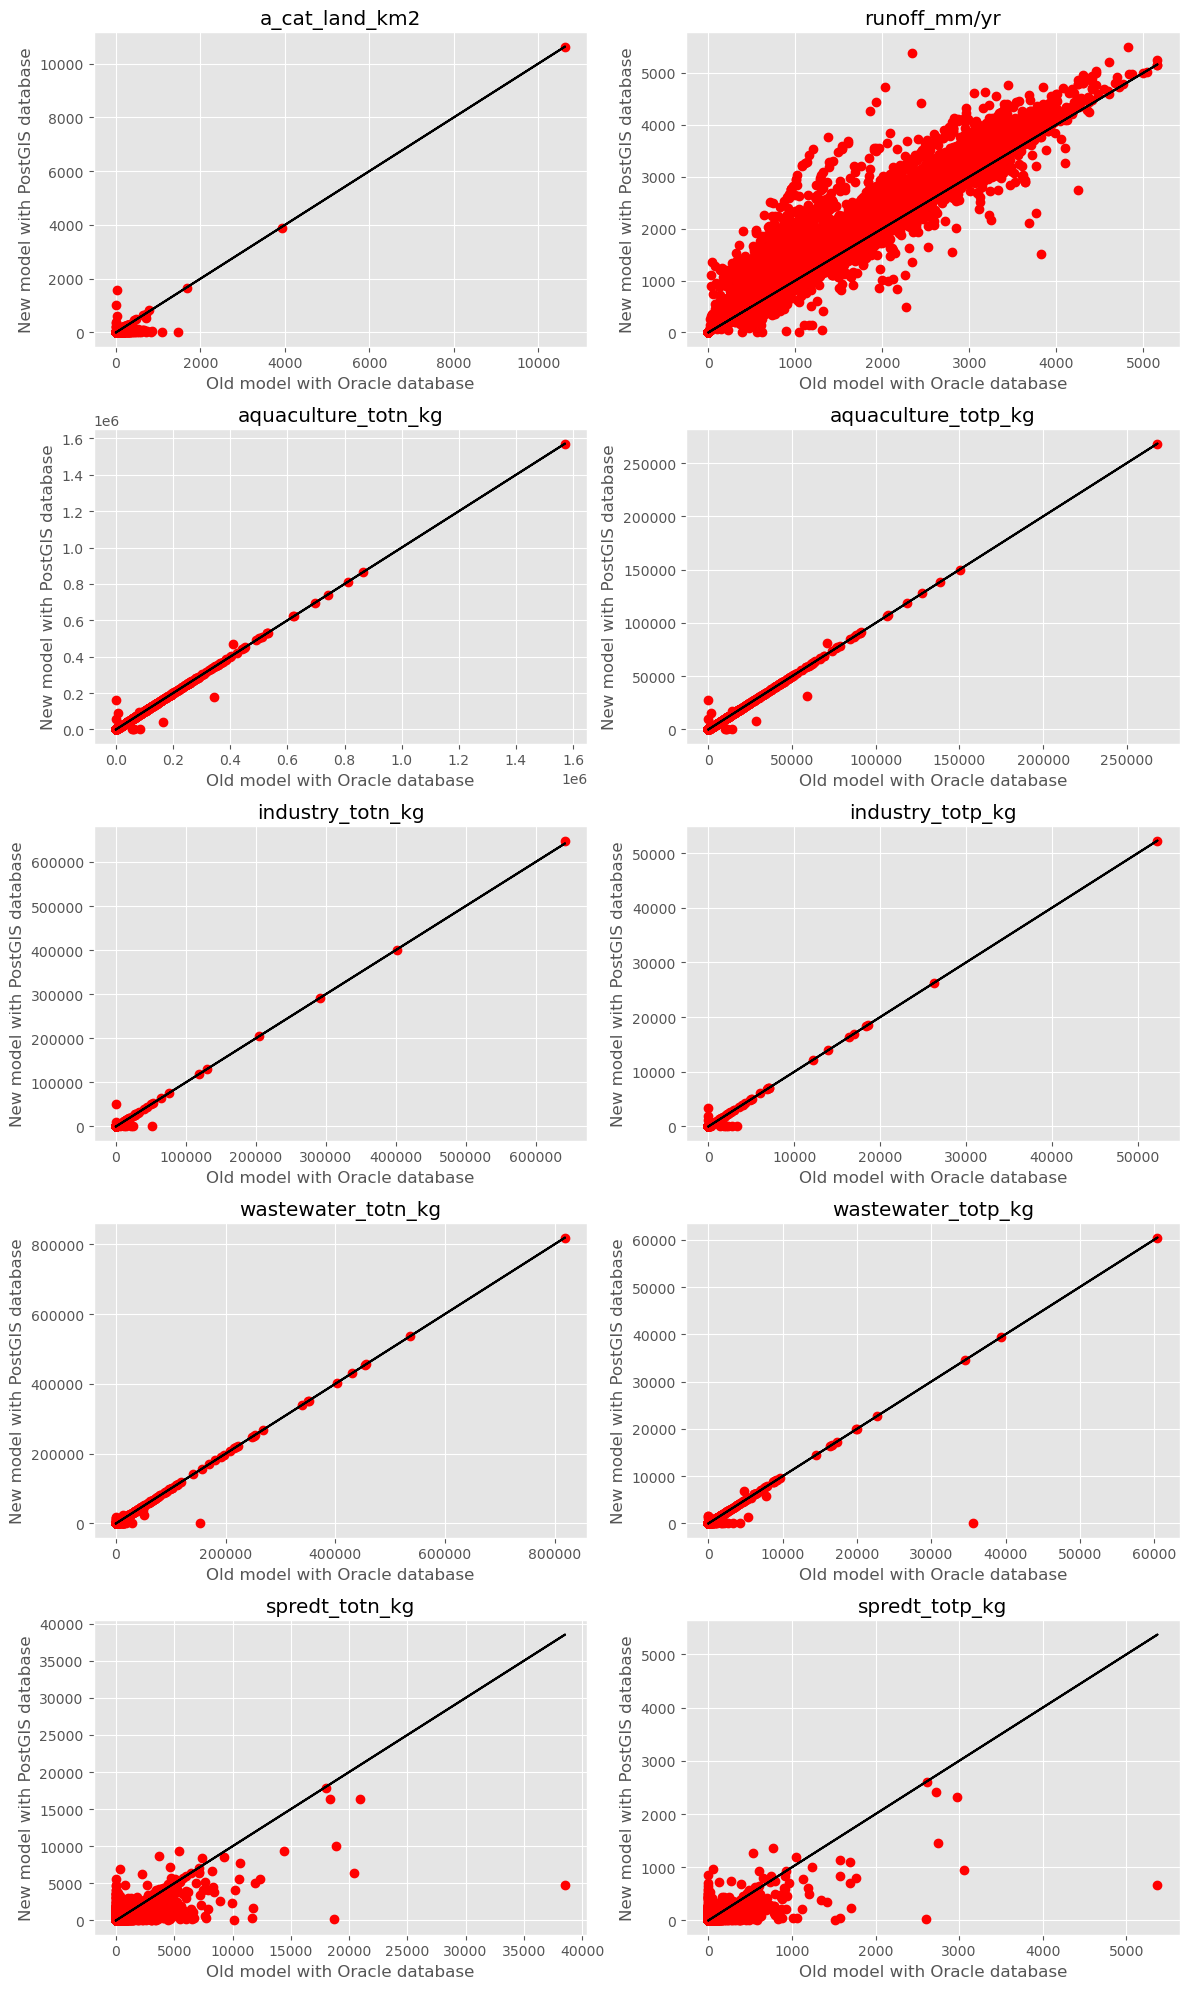

In [7]:
# Join old and new datasets
df = pd.merge(teo3_df, teo2_df, how="inner", on="regine", suffixes=["_new", "_old"])

# Plot
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(12, 20))
axes = axes.flatten()
cols.remove("regine")
for idx, col in enumerate(cols):
    axes[idx].plot(df[f"{col}_old"], df[f"{col}_new"], "ro")
    axes[idx].plot(df[f"{col}_old"], df[f"{col}_old"], "k-", label="1:1 line")
    axes[idx].set_title(col)
    axes[idx].set_xlabel("Old model with Oracle database")
    axes[idx].set_ylabel("New model with PostGIS database")
plt.tight_layout()